## Imports

In [8]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.analysis.graph_community_analyzer_graph_tool import GraphCommunityAnalyzerGraphTool

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from graph_tool.all import load_graph, GraphView, graph_draw, prop_to_size, closeness, eigenvector
from graph_tool import openmp_set_num_threads

## Initialize Graphs

In [9]:
openmp_set_num_threads(8)

# 'Artificial intelligence' not yet done
graph_names = ['Amiga_CD32_games', 'Machine_learning','Game_Boy_games']

graphs = [{"graph_name": graph_name, "graph": load_graph('outputs/graphs/{}.gt'.format(graph_name))} for graph_name in graph_names]


In [10]:
for graph_instance in graphs:
    print(f"-------------Graph: {graph_instance['graph_name']}-------------")
    num_nodes = graph_instance['graph'].num_vertices()
    num_edges = graph_instance['graph'].num_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


-------------Graph: Amiga_CD32_games-------------
Number of nodes: 8013
Number of edges: 1537410
-------------Graph: Machine_learning-------------
Number of nodes: 75217
Number of edges: 26149964
-------------Graph: Game_Boy_games-------------
Number of nodes: 8953
Number of edges: 4095265


## Community detection

In [11]:
graph_comm = graphs[0]['graph']
graph_name = graphs[0]['graph_name']

graph_community_analyzer = GraphCommunityAnalyzerGraphTool(graph_comm, 'outputs/graphs/{}_communities'.format(graph_name))
# graph_community_analyzer.calc_minimize_blockmodel_dl(output_plot=False)

Graph: 8013 vertices, 1537410 edges
Randomized Graph: 8013 vertices, 1537410 edges


In [12]:
mod_state = graph_community_analyzer.calc_modularity_maximization(output_plot=False,niter=1000)
mod_state_random = graph_community_analyzer.calc_modularity_maximization(output_plot=False, niter=1000, is_random=True)

Number of blocks: 26
Number of blocks: 29


In [13]:
from src.analysis.utils import get_node_ids_from_community, plot_stats_for_category_quarterly

from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db

db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)


Database initialized: wikipedia.db


In [38]:
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()

community_counts = Counter(property_map_communities)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)

first_id = sorted_list_of_community_ids_by_size[0]
last_id = sorted_list_of_community_ids_by_size[-1]

nodes_in_community_first = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], first_id)
nodes_in_community_last = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], last_id)

In [58]:
def plot_stats_for_category_quarterly(df, category_name):
    # Convert month to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['month']):
        df['month'] = pd.to_datetime(df['month'])
    
    # Add a 'quarter' column based on the 'month'
    df['quarter'] = df['month'].dt.to_period('Q')
    
    # Create a complete date range from min to max date
    min_quarter = df['quarter'].min()
    max_quarter = df['quarter'].max()
    all_quarters = pd.period_range(start=min_quarter, end=max_quarter, freq='Q')
    
    # Create a DataFrame with all quarters
    complete_quarters_df = pd.DataFrame(index=all_quarters)
    complete_quarters_df.index.name = 'quarter'
    
    # Aggregate data by quarter
    quarterly_df = (
        df.groupby('quarter')[['total_contributions', 'unique_pages', 'unique_contributors']]
        .sum()
    )
    
    # Merge actual data with complete quarter range and fill NAs with 0
    quarterly_df = (
        complete_quarters_df
        .join(quarterly_df)
        .fillna(0)
        .reset_index()
    )
    
    # Convert the 'quarter' to string for plotting
    quarterly_df['quarter'] = quarterly_df['quarter'].astype(str)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(quarterly_df['quarter'], quarterly_df['unique_pages'], 
             label='Unique Pages')
    plt.plot(quarterly_df['quarter'], quarterly_df['unique_contributors'], 
             label='Unique Contributors')
    plt.plot(quarterly_df['quarter'], quarterly_df['total_contributions'], 
             label='Total Contributions')
    
    plt.title(f'Quarterly Statistics for Main Category: {category_name}')
    plt.xlabel('Quarter')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Customize x-axis ticks: Show every 5th year
    xticks = quarterly_df['quarter'][::20]  # Adjust the interval as needed
    plt.xticks(ticks=range(0, len(quarterly_df['quarter']), 20), 
               labels=xticks, rotation=45)
    
    plt.tight_layout()
    plt.show()

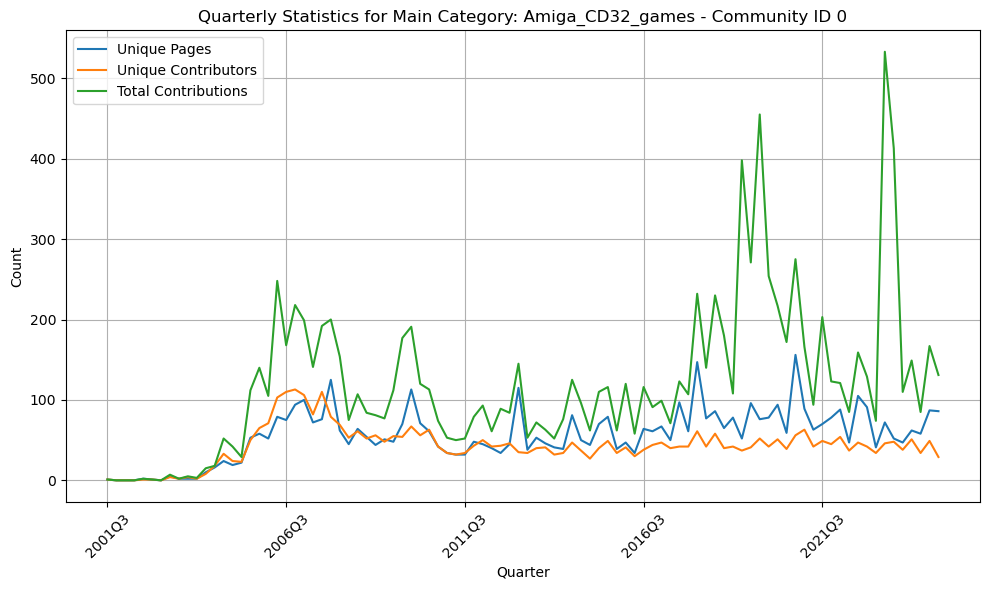

        month  total_contributions  unique_pages  unique_contributors
0  2005-10-01                    1             1                    1
1  2006-05-01                    1             1                    1
2  2006-06-01                    6             1                    1
3  2006-09-01                    3             2                    3
4  2006-10-01                    2             2                    2
5  2007-08-01                    1             1                    1
6  2008-12-01                    1             1                    1
7  2010-08-01                    1             1                    1
8  2011-10-01                    1             1                    1
9  2012-01-01                    1             1                    1
10 2012-04-01                    2             1                    1
11 2016-09-01                    1             1                    1


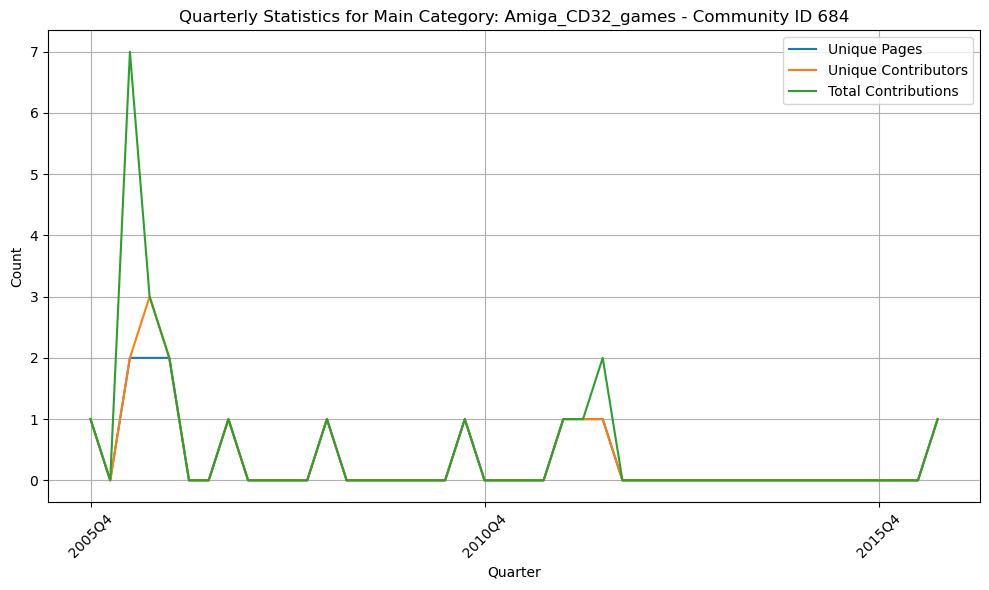

In [59]:
import pandas as pd

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_first)
plot_stats_for_category_quarterly(df, f'Amiga_CD32_games - Community ID {first_id}')

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_last)
print(df)
plot_stats_for_category_quarterly(df, f'Amiga_CD32_games - Community ID {last_id}')

In [6]:
# print(f'Modularity Blockmodel: {graph_community_analyzer.calculate_modularity_newman(comm_type="blockmodel")}')
print(f'Modularity Modularity Maximization: {graph_community_analyzer.calculate_modularity_newman(comm_type="modularity")}')
print(f'Modularity Modularity Maximization Random: {graph_community_analyzer.calculate_modularity_newman(comm_type="modularity", is_random=True)}')

Modularity Modularity Maximization: 0.4415773293188393
Modularity Modularity Maximization Random: 0.04862073265085417


### Get community vertex property

In [7]:
print(f"communities {graph_community_analyzer.communities}")
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()
property_map_communities_random = graph_community_analyzer.communities['communities_modularity_random'].get_array()


communities {'communities_modularity': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f12ed0e9dd0, at 0x7f12ef071410>, 'communities_modularity_random': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f12ef063950, at 0x7f12ea1294d0>}


### Plot community sizes

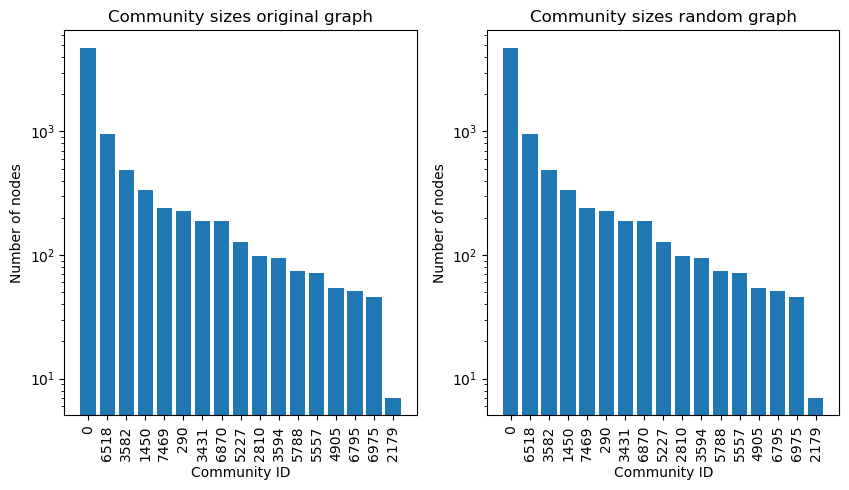

In [8]:
#plot community sizes

community_counts = Counter(property_map_communities)
community_counts_random = Counter(property_map_communities_random)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)
sorted_list_of_community_ids_by_size_random = sorted(community_counts_random, key=community_counts_random.get, reverse=True)



fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sorted_community_counts = {community: community_counts[community] for community in sorted_list_of_community_ids_by_size}

x_label_strings = [f'{community}' for community in sorted_community_counts.keys()]
x = np.arange(len(sorted_community_counts.keys()))
axs[0].bar(x, sorted_community_counts.values())
axs[0].set_title('Community sizes original graph')
axs[0].set_xlabel('Community ID')
axs[0].set_ylabel('Number of nodes')
axs[0].set_yscale('log')
axs[0].set_xticks(x)
axs[0].set_xticklabels(x_label_strings, rotation=90)

sorted_community_counts_random = {community: community_counts[community] for community in sorted_list_of_community_ids_by_size}
x_label_strings_random = [f'{community}' for community in sorted_community_counts_random.keys()]
x_random = np.arange(len(sorted_community_counts_random.keys()))
axs[1].bar(x_random, sorted_community_counts_random.values())
axs[1].set_title('Community sizes random graph')
axs[1].set_xlabel('Community ID')
axs[1].set_ylabel('Number of nodes')
axs[1].set_yscale('log')
axs[1].set_xticks(x_random)
axs[1].set_xticklabels(x_label_strings_random, rotation=90)

plt.show()




## Visualize Biggest N Communities

In [9]:
# biggest_n_communities = 5

# communities = Counter(property_map_communities)
# biggest_communities = communities.most_common(biggest_n_communities)
# print(f"Biggest communities: {biggest_communities}")

# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# # community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# for i in range(1, biggest_n_communities):
#     community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == biggest_communities[i][0], True, False))
# print(f"len community_bool_filter: {len(community_bool_filter)}")
# print(f"community_bool_filter: {community_bool_filter[:10]}")
# print(f"property_map_communities: {property_map_communities[:10]}")

# print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

# print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
# print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

# filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# # graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# # color mapping for communities
# color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7'}
# # color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7', 5: '#cf720f', 6: '#72ca72', 7: '#cf7202', 8: '#72cf72', 9: '#0f720f'}
# color_map_from_biggest_communities_indexes = {biggest_communities[i][0]: color_map[i] for i in range(biggest_n_communities)}

# print(f"color_map_from_biggest_communities_indexes {color_map_from_biggest_communities_indexes}")

# vcolor = graph_community_analyzer.graph.new_vp("string") 

# print(f"vcolor type: {type(vcolor)}")
# print(f"filter_mask type: {type(filter_mask)}")

# for v in graph_community_analyzer.graph.vertices():
#     if graph_community_analyzer.graph.vertex_index[v] in np.where(community_bool_filter)[0]:
#         vcolor[v] = color_map_from_biggest_communities_indexes[property_map_communities[graph_community_analyzer.graph.vertex_index[v]]]

# # fill all vcolor values with black if not in filter_mask
# for v in graph_community_analyzer.graph.vertices():
#     if vcolor[v] == "":
#         vcolor[v] = '#000000'

# u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
# graph_draw(u, vertex_fill_color=vcolor)






## Visualize smallest 5 communities

In [10]:
# # visualize smallest 5 communities
# n_smallest_communities = 8

# smallest_communities = communities.most_common()[:-(n_smallest_communities+1):-1]
# print(f"Smallest communities: {smallest_communities}")

# community_bool_filter = np.where(property_map_communities == smallest_communities[0][0], True, False)
# # community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# for i in range(1, n_smallest_communities):
#     community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == smallest_communities[i][0], True, False))
# print(f"len community_bool_filter: {len(community_bool_filter)}")
# print(f"community_bool_filter: {community_bool_filter[:10]}")
# print(f"property_map_communities: {property_map_communities[:10]}")

# print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

# print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
# print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

# filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# # graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
# graph_draw(u, vertex_fill_color=prop_to_size(graph_community_analyzer.communities['communities_modularity'], 0,1, power=.1))


## Get statistics of communities

### Init DB to query contributor information

In [11]:
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
from datetime import datetime

db_category_names = ['Amiga CD32 games', 'Machine learning', 'Game Boy games', 'Artificial intelligence']

category_name  = db_category_names[0]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

Database initialized: wikipedia.db


In [12]:
def get_edit_stats_for_category(graph_community_analyzer, category_name):
    main_category_id = db_manager.get_main_category_by_name(category_name)

    # get all vertex properties
    vertex_properties = graph_community_analyzer.graph.vertex_properties
    #get id property
    id_property = vertex_properties['id']

    # construct a dict with the community as key and the nodes, stats as values
    community_stats = {'max': {}, 'min': {}, 'avg': {}, 'total': {}}
    community_nodes = {}
    community_nodes_nb_edits = {}
    nodes_oldest_edit = {}
    nodes_newest_edit = {}
    community_oldest_edit = {}
    community_newest_edit = {}

    for v in graph_community_analyzer.graph.vertices():
        community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]
        if community not in community_nodes:
            community_nodes[community] = []
            community_nodes_nb_edits[community] = []
        community_nodes[community].append(v)
        community_nodes_nb_edits[community].append(db_manager.get_number_of_revisions_per_contributor(id_property[v], main_category_id))
        node_edit_dates = db_manager.get_oldest_and_newest_revision_per_contributor_and_main_category(id_property[v], main_category_id)

        #parse date string as datetime
        node_edit_dates['oldest_revision'] = datetime.strptime(node_edit_dates['oldest_revision'], '%Y-%m-%dT%H:%M:%SZ')
        node_edit_dates['newest_revision'] = datetime.strptime(node_edit_dates['newest_revision'], '%Y-%m-%dT%H:%M:%SZ')

        nodes_oldest_edit[int(v)] = node_edit_dates['oldest_revision']
        nodes_newest_edit[int(v)] = node_edit_dates['newest_revision']
        
        if community not in community_oldest_edit:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']
            community_newest_edit[community] = node_edit_dates['newest_revision']

        if community_oldest_edit[community] > node_edit_dates['oldest_revision']:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']

        if community_newest_edit[community] < node_edit_dates['newest_revision']:
            community_newest_edit[community] = node_edit_dates['newest_revision']

    for community in community_nodes_nb_edits.keys():
        community_stats['max'][community] = np.max(community_nodes_nb_edits[community])
        community_stats['min'][community] = np.min(community_nodes_nb_edits[community])
        community_stats['avg'][community] = np.mean(community_nodes_nb_edits[community])
        community_stats['total'][community] = np.sum(community_nodes_nb_edits[community])

    print(f"community_nodes: {community_nodes}")
    print(f"len community_nodes: {len(community_nodes.keys())}")

    #Total number of edits in category
    print(f"Total number of edits in category {category_name}: {db_manager.get_total_number_of_revisions_per_main_category(main_category_id)}")
    #Average number of edits per contributor
    print(f"Average edits of category {category_name}: {np.mean([np.mean(community_nodes_nb_edits[community]) for community in community_nodes_nb_edits.keys()])}")

    return community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit

community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit = get_edit_stats_for_category(graph_community_analyzer, category_name)


community_nodes: {np.int32(6518): [<Vertex object with index '0' at 0x7f12ed0752c0>, <Vertex object with index '1' at 0x7f12e8961940>, <Vertex object with index '3' at 0x7f13734461c0>, <Vertex object with index '4' at 0x7f12e87314c0>, <Vertex object with index '5' at 0x7f12e8730b40>, <Vertex object with index '6' at 0x7f12e87313c0>, <Vertex object with index '8' at 0x7f12e87316c0>, <Vertex object with index '9' at 0x7f12e8731740>, <Vertex object with index '10' at 0x7f12e87317c0>, <Vertex object with index '11' at 0x7f12e87319c0>, <Vertex object with index '12' at 0x7f12e8731840>, <Vertex object with index '13' at 0x7f12e8731540>, <Vertex object with index '14' at 0x7f12e8731bc0>, <Vertex object with index '18' at 0x7f12e8731e40>, <Vertex object with index '20' at 0x7f12e8731f40>, <Vertex object with index '21' at 0x7f12e8731fc0>, <Vertex object with index '24' at 0x7f12e8732140>, <Vertex object with index '26' at 0x7f12e8731640>, <Vertex object with index '27' at 0x7f12e8731ac0>, <Ver

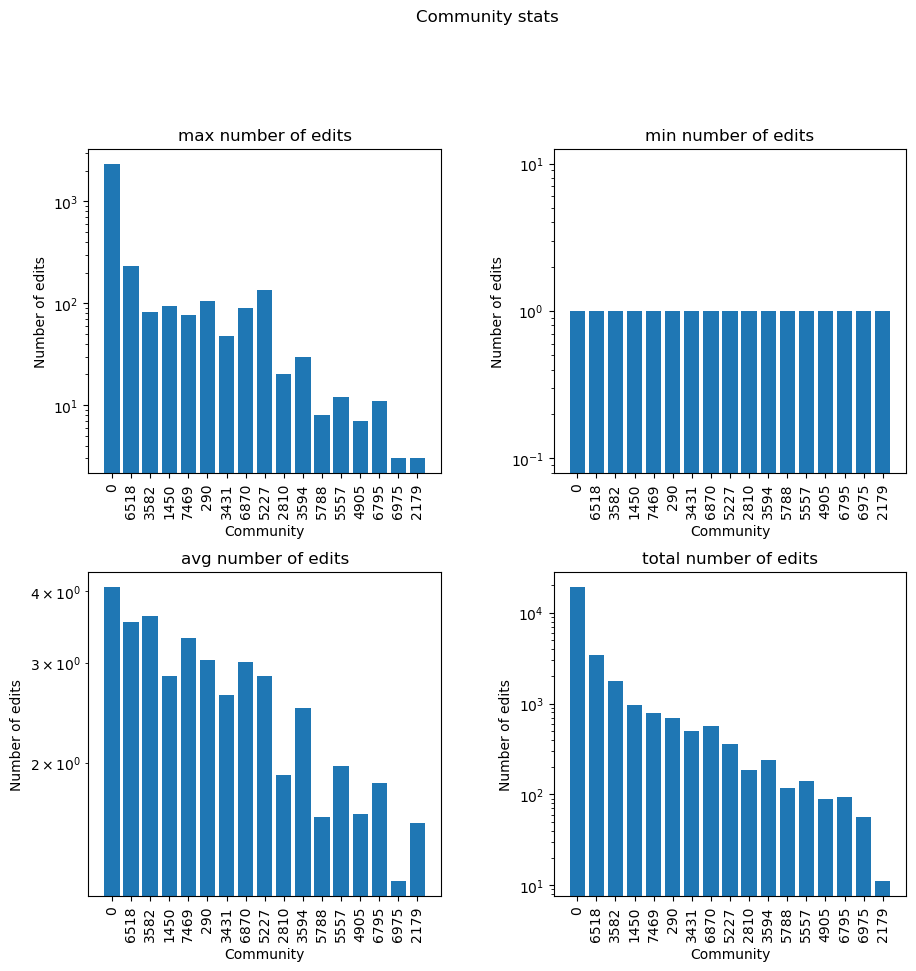

In [13]:
#plot distribution of stats over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community stats')
fig.tight_layout(pad=5.0)

for i, stat in enumerate(community_stats.keys()):
    ax = axs[i//2, i%2]

    # sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
    sorted_community_stats = {community: community_stats[stat][community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_community_stats.keys()]
    x = np.arange(len(sorted_community_stats.keys()))
    y = list(sorted_community_stats.values())
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_yscale('log')
    ax.set_title(f'{stat} number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel('Community')
    
plt.show()

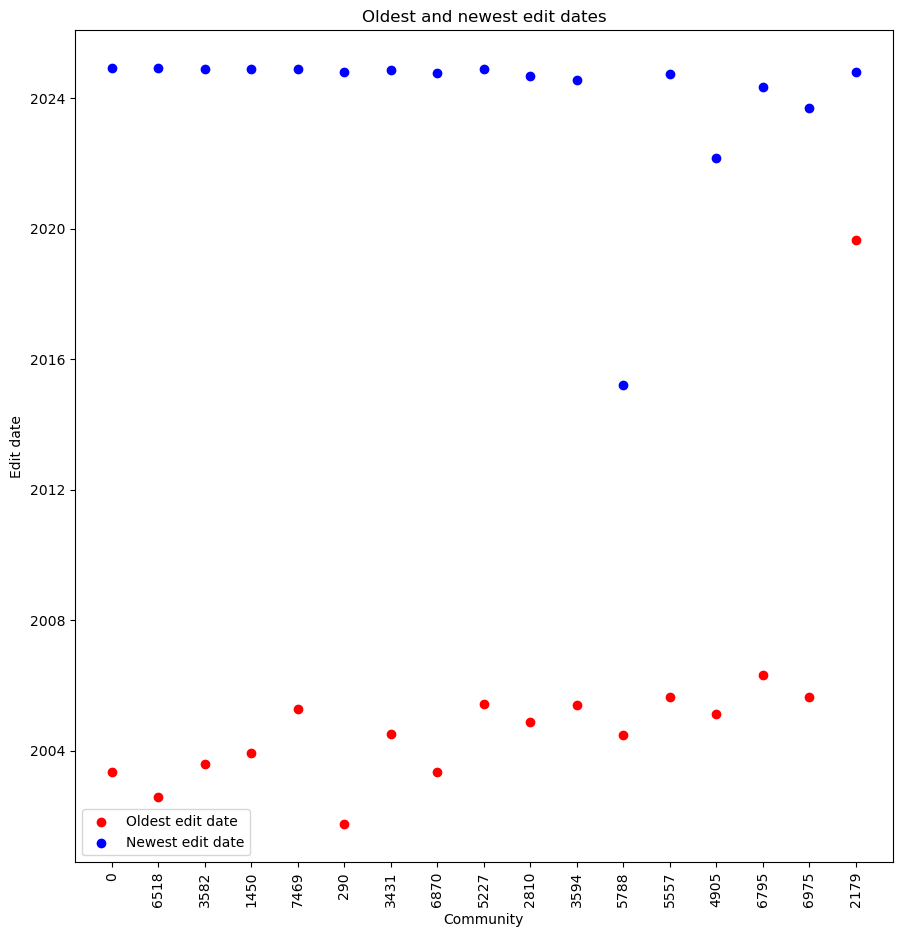

In [14]:
# plot oldest and newest edit dates as scatter plot with the oldest and newest edit dates as different colors for each community in the y-axis

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
sorted_oldest_edit = {community: community_oldest_edit[community] for community in sorted_list_of_community_ids_by_size}
sorted_newest_edit = {community: community_newest_edit[community] for community in sorted_list_of_community_ids_by_size}

x = np.arange(len(sorted_oldest_edit.keys()))
x_label_strings = [f'{community}' for community in sorted_oldest_edit.keys()]
y1 = sorted_oldest_edit.values()
y2 = sorted_newest_edit.values()
# print(len(x), len(y1), len(y2))

# print(type(list(y1)[0]))

# print(x)
# print(y1)
ax.scatter(x, y1, color='r', label='Oldest edit date')
ax.scatter(x, y2, color='b', label='Newest edit date')
ax.set_xticks(x)
ax.set_xticklabels(x_label_strings, rotation=90)
ax.set_title('Oldest and newest edit dates')
ax.set_ylabel('Edit date')
ax.set_xlabel('Community')
ax.legend()

plt.show()

## Analyze graph properties and plot them per community

In [15]:
centrality_analyzer = CentralityAnalyzer(graph_community_analyzer.graph)
centrality_analyzer.calculate_centralities()

closn = centrality_analyzer.get_closeness_centrality()
eigenv = centrality_analyzer.get_eigenvector_centrality()
betweenness = centrality_analyzer.get_betweenness_centrality()
degrees = centrality_analyzer.get_degrees()




Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.15 seconds.

Calculating closeness...
Closeness centrality calculated in 40.46 seconds.

Calculating betweenness...
Betweenness centrality calculated in 54.47 seconds.



In [16]:
community_closeness = {}
community_eigenvector = {}
community_betweenness = {}
community_degrees = {}

# get closeness centrality for each community
for v in graph_community_analyzer.graph.vertices():
    community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]

    if community not in community_closeness:
        community_closeness[community] = []
    community_closeness[community].append(closn[graph_community_analyzer.graph.vertex_index[v]])

    # get eigenvector centrality for each community
    if community not in community_eigenvector:
        community_eigenvector[community] = []
    community_eigenvector[community].append(eigenv[graph_community_analyzer.graph.vertex_index[v]])

    # get betweenness centrality for each community
    if community not in community_betweenness:
        community_betweenness[community] = []
    community_betweenness[community].append(betweenness[graph_community_analyzer.graph.vertex_index[v]])

    # get degrees for each community
    if community not in community_degrees:
        community_degrees[community] = []
    community_degrees[community].append(degrees[graph_community_analyzer.graph.vertex_index[v]])


### Get usernames of high centrality nodes

In [17]:
#print ids of nodes with hightest centrality measures
max_closeness = np.max(closn)
max_eigenvector = np.max(eigenv)
max_betweenness = np.max(betweenness)
max_degree = np.max(degrees)


In [18]:
top_N_centrality_nodes = 20

top_closeness_nodes = np.flip(np.argsort(closn)[-top_N_centrality_nodes:])
top_eigenvector_nodes = np.flip(np.argsort(eigenv)[-top_N_centrality_nodes:])
top_betweenness_nodes = np.flip(np.argsort(betweenness)[-top_N_centrality_nodes:])
top_degree_nodes = np.flip(np.argsort(degrees)[-top_N_centrality_nodes:])

top_closeness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_closeness_nodes]
top_eigenvector_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_eigenvector_nodes]
top_betweenness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_betweenness_nodes]
top_degree_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_degree_nodes]

top_closeness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_closeness_nodes_ids]
top_eigenvector_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_eigenvector_nodes_ids]
top_betweenness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_betweenness_nodes_ids]
top_degree_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_degree_nodes_ids]
 
print("------------ Closeness ---------------")
for i in range(len(top_closeness_nodes)):
    print(f"Closeness: {closn[top_closeness_nodes[i]]}:\t {top_closeness_nodes_usernames[i]}")

print("------------ Eigenvector ---------------")
for i in range(len(top_eigenvector_nodes)):
    print(f"Eigenvector: {eigenv[top_eigenvector_nodes[i]]}:\t {top_eigenvector_nodes_usernames[i]}")

print("------------ Betweenness ---------------")
for i in range(len(top_betweenness_nodes)):
    print(f"Betweenness: {betweenness[top_betweenness_nodes[i]]}:\t {top_betweenness_nodes_usernames[i]}")

print("------------ Degree ---------------")
for i in range(len(top_degree_nodes)):
    print(f"Degree: {degrees[top_degree_nodes[i]]}:\t {top_degree_nodes_usernames[i]}")



------------ Closeness ---------------
Closeness: 0.9946617008069523:	 JJMC89 bot III
Closeness: 0.9408172851103805:	 Cydebot
Closeness: 0.9392731535756155:	 Waxworker
Closeness: 0.9165999313579682:	 Addbot
Closeness: 0.9154478976234004:	 Mika1h
Closeness: 0.9017445132245357:	 Citation bot
Closeness: 0.876970227670753:	 Monkbot
Closeness: 0.8708695652173913:	 X201
Closeness: 0.8538846850687413:	 BetacommandBot
Closeness: 0.8301730390633095:	 Phediuk
Closeness: 0.8278569952469519:	 AnomieBOT
Closeness: 0.8177179016125741:	 SmackBot
Closeness: 0.8039333734697973:	 InternetArchiveBot
Closeness: 0.7903719049028312:	 Dgpop
Closeness: 0.7768835450402405:	 IceWelder
Closeness: 0.7702364929821188:	 The1337gamer
Closeness: 0.7697185128254396:	 KGRAMR
Closeness: 0.7532198928269248:	 GreenC bot
Closeness: 0.7339684866251374:	 N. Harmonik
Closeness: 0.7338340355376443:	 Martin IIIa
------------ Eigenvector ---------------
Eigenvector: 0.04626750201797862:	 JJMC89 bot III
Eigenvector: 0.04588331815

### Plot distributions of mean centrality measures per community

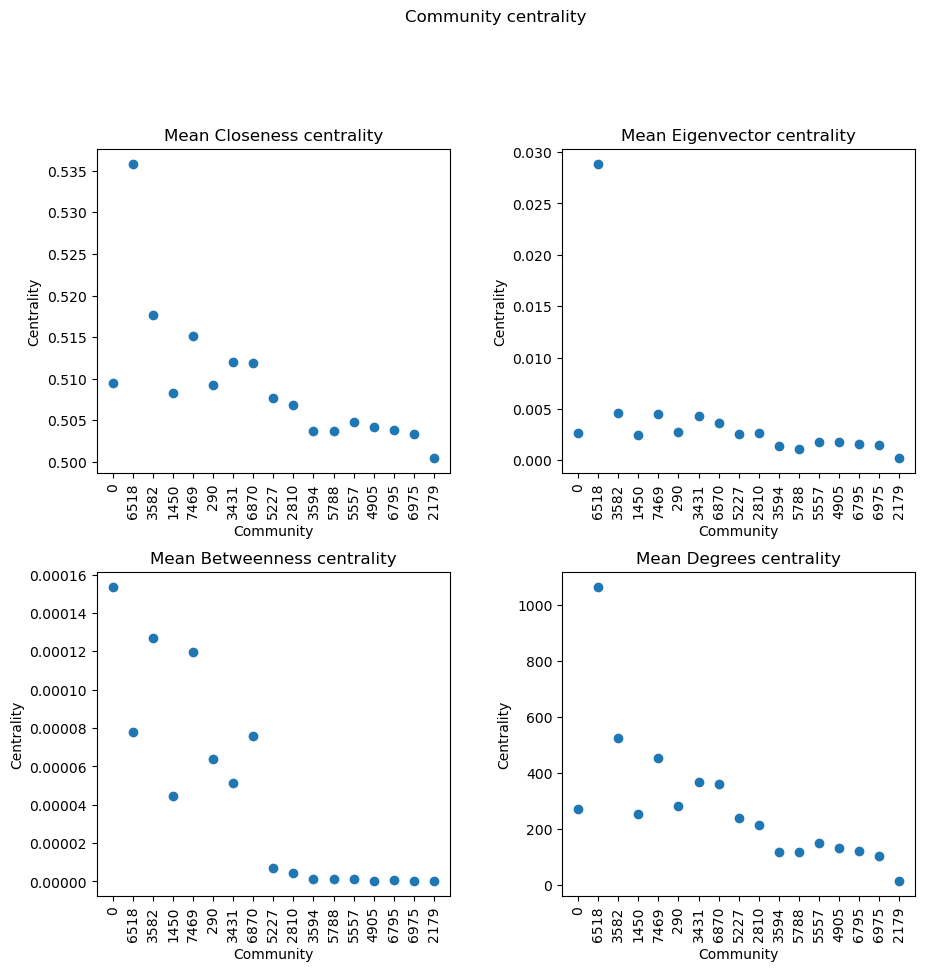

In [19]:
#plot distribution of closeness and eigenvector centrality over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community centrality')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'

    sorted_centrality = {community: centrality[community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_centrality.keys()]
    x = np.arange(len(sorted_centrality.keys()))
    y = [np.mean(sorted_centrality[community]) for community in sorted_centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'

    sorted_centrality = {community: centrality[community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_centrality.keys()]
    x = np.arange(len(sorted_centrality.keys()))
    y = [np.mean(sorted_centrality[community]) for community in sorted_centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

plt.show()


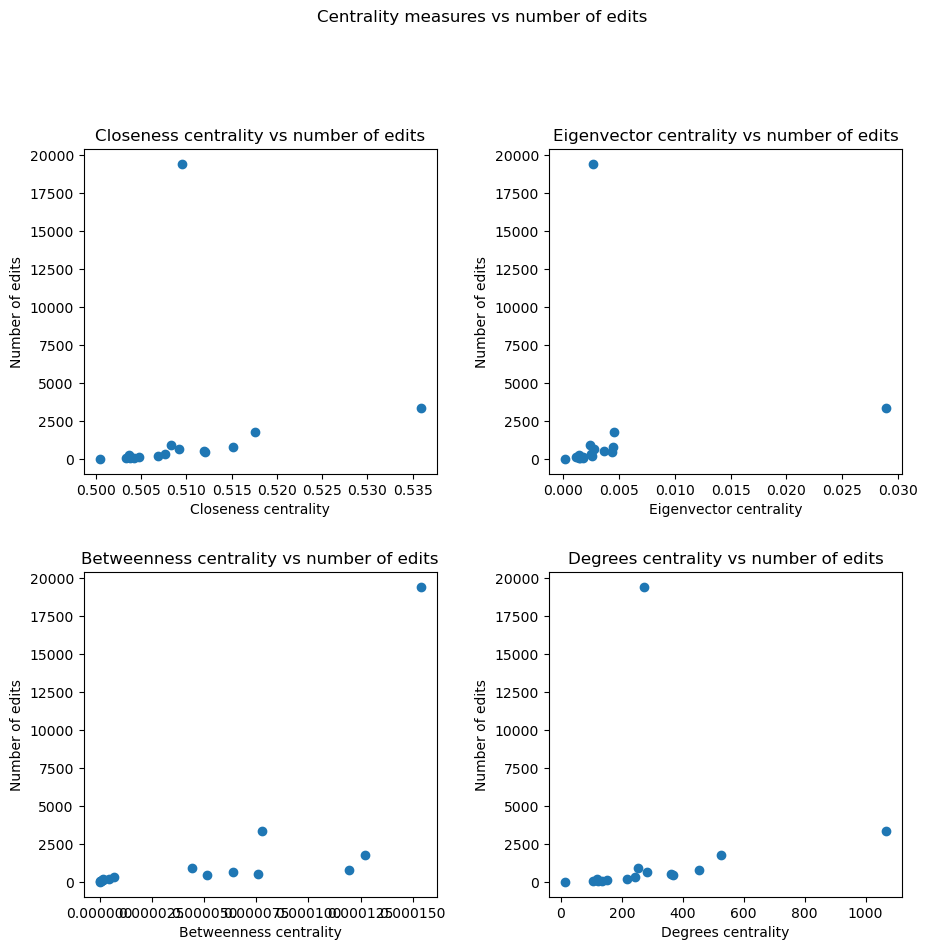

In [20]:
# plot centrality measures against number of edits for each community

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Centrality measures vs number of edits')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    labels = [f'{community}' for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')